In [ ]:
import os
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Modern TensorFlow Keras API
from tensorflow.keras.utils import to_categorical  # one-hot encoding
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Model, backend as K
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

%matplotlib inline


In [2]:
X_train = np.load("../data/256_192_train.npy")
y_train = np.load("../data/train_labels.npy")
X_val = np.load("../data/256_192_val.npy")
y_val = np.load("../data/val_labels.npy")
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [3]:
pre_trained_model = DenseNet201(input_shape=(192, 256, 3), include_top=False, weights="imagenet")

2025-05-05 14:45:14.239813: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-05-05 14:45:14.239983: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-05-05 14:45:14.239990: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-05-05 14:45:14.240215: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-05 14:45:14.240236: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [4]:
from tensorflow.keras.layers import BatchNormalization

# Freeze all layers except BatchNormalization layers
for layer in pre_trained_model.layers:
    print(layer.name)
    if isinstance(layer, BatchNormalization):
        layer.trainable = True  # Fine-tune BatchNorm stats
    else:
        layer.trainable = False

print("Total layers:", len(pre_trained_model.layers))


input_layer
zero_padding2d
conv1_conv
conv1_bn
conv1_relu
zero_padding2d_1
pool1
conv2_block1_0_bn
conv2_block1_0_relu
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_concat
conv2_block2_0_bn
conv2_block2_0_relu
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_concat
conv2_block3_0_bn
conv2_block3_0_relu
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_concat
conv2_block4_0_bn
conv2_block4_0_relu
conv2_block4_1_conv
conv2_block4_1_bn
conv2_block4_1_relu
conv2_block4_2_conv
conv2_block4_concat
conv2_block5_0_bn
conv2_block5_0_relu
conv2_block5_1_conv
conv2_block5_1_bn
conv2_block5_1_relu
conv2_block5_2_conv
conv2_block5_concat
conv2_block6_0_bn
conv2_block6_0_relu
conv2_block6_1_conv
conv2_block6_1_bn
conv2_block6_1_relu
conv2_block6_2_conv
conv2_block6_concat
pool2_bn
pool2_relu
pool2_conv
pool2_pool
conv3_block1_0_bn
conv3_block1_0_relu
conv3_block1_1_conv
con

In [6]:
last_layer = pre_trained_model.get_layer('relu')
print('last layer output shape:', last_layer.output.shape)
last_output = last_layer.output

last layer output shape: (None, 6, 8, 1920)


In [7]:
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.7
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(7, activation='softmax')(x)

# Configure and compile the model

model = Model(pre_trained_model.input, x)
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
model.summary()

/Users/ankitsanjyal/Library/Python/3.9/lib/python/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 192, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 198, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 96, 128,   │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 96, 128,   │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 96, 128,   │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 98, 130,   │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 48, 64,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 48, 64,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 48, 64,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 48, 64,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 48, 64,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 48, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 48, 64,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 48, 64,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 48, 64,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 48, 64,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 48, 64,    │     12,288 │ conv2_block2_0_r

 Total params: 19,309,127 (73.66 MB)

 Trainable params: 1,216,199 (4.64 MB)

 Non-trainable params: 18,092,928 (69.02 MB)

# Training
### Feature Extraction

In [8]:
train_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

In [9]:
batch_size = 32
epochs = 3
history = model.fit(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size), 
                              validation_steps=(X_val.shape[0] // batch_size))

/Users/ankitsanjyal/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3


2025-05-05 14:47:08.509869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


253/253 ━━━━━━━━━━━━━━━━━━━━ 736s 3s/step - accuracy: 0.5220 - loss: 4.6765 - val_accuracy: 0.6696 - val_loss: 2.2513
Epoch 2/3
  1/253 ━━━━━━━━━━━━━━━━━━━━ 11:49 3s/step - accuracy: 0.6562 - loss: 2.4936

/Users/ankitsanjyal/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


253/253 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.6562 - loss: 2.4936 - val_accuracy: 0.6696 - val_loss: 2.3242
Epoch 3/3
253/253 ━━━━━━━━━━━━━━━━━━━━ 571s 2s/step - accuracy: 0.6188 - loss: 3.3611 - val_accuracy: 0.7031 - val_loss: 2.1997


### Finetuning

In [10]:
pre_trained_model.layers[481].name



'conv5_block1_0_bn'

In [11]:
for layer in pre_trained_model.layers[481:]:
    layer.trainable = True

In [16]:
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

/Users/ankitsanjyal/Library/Python/3.9/lib/python/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [17]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)

In [18]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 192, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 198, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 96, 128,   │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 96, 128,   │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 96, 128,   │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 98, 130,   │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 48, 64,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 48, 64,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 48, 64,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 48, 64,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 48, 64,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 48, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 48, 64,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 48, 64,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 48, 64,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 48, 64,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 48, 64,    │     12,288 │ conv2_block2_0_r

 Total params: 19,309,127 (73.66 MB)

 Trainable params: 8,097,479 (30.89 MB)

 Non-trainable params: 11,211,648 (42.77 MB)

In [19]:
batch_size = 32
epochs = 25
history = model.fit(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              validation_steps=(X_val.shape[0] // batch_size),
                              callbacks=[learning_rate_reduction])

/Users/ankitsanjyal/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 1034s 4s/step - acc: 0.6456 - loss: 3.0795 - val_acc: 0.7768 - val_loss: 1.6707 - learning_rate: 1.0000e-04
Epoch 2/25
  1/253 ━━━━━━━━━━━━━━━━━━━━ 13:24 3s/step - acc: 0.8125 - loss: 1.3934

/Users/ankitsanjyal/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


253/253 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - acc: 0.8125 - loss: 1.3934 - val_acc: 0.7734 - val_loss: 1.7095 - learning_rate: 1.0000e-04
Epoch 3/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 804s 3s/step - acc: 0.7103 - loss: 2.7195 - val_acc: 0.7935 - val_loss: 1.5478 - learning_rate: 1.0000e-04
Epoch 4/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - acc: 0.6875 - loss: 2.4936 - val_acc: 0.7969 - val_loss: 1.5652 - learning_rate: 1.0000e-04
Epoch 5/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 878s 3s/step - acc: 0.7262 - loss: 2.5065 - val_acc: 0.7801 - val_loss: 1.6091 - learning_rate: 1.0000e-04
Epoch 6/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - acc: 0.6875 - loss: 2.6540 - val_acc: 0.7779 - val_loss: 1.6118 - learning_rate: 1.0000e-04
Epoch 7/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - acc: 0.7582 - loss: 2.1923
Epoch 7: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
253/253 ━━━━━━━━━━━━━━━━━━━━ 1605s 6s/step - acc: 0.7582 - loss: 2.1919 - val_acc: 0.7969 - val_loss: 1.2828 - learning_

In [20]:
loss_val, acc_val = model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 257ms/step - acc: 0.8365 - loss: 1.2680
Validation: accuracy = 0.834812  ;  loss_v = 1.331921


In [21]:
model.save('../models/Densenet.h5')

### Testing

In [22]:
X_test = np.load("../data/256_192_test.npy")
y_test = np.load("../data/test_labels.npy")
y_test = to_categorical(y_test)

loss_test, acc_test = model.evaluate(X_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - acc: 0.8126 - loss: 1.5389
Test: accuracy = 0.825349  ;  loss = 1.504203


Text(0.5, 1.0, 'Training and validation loss')

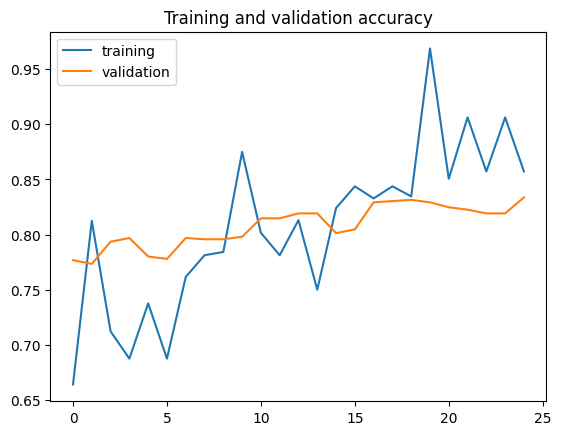

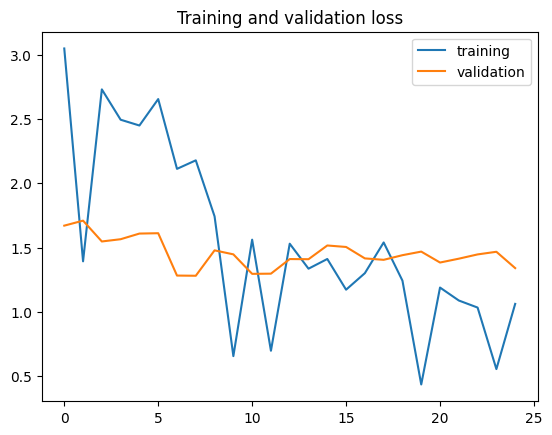

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')